# Free Spoken Digit classification

In this exercise you will build a complete data analytics pipeline to pre-process your audio signals and build a classification model able to distinguish between the classes available in the dataset.

More specifically, you will load, analyze and prepare the Free Spoken Digit dataset to train and validate a classification model.

In [32]:
# import cell
from os import listdir
from os.path import join

from scipy.io.wavfile import read as read_wav

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# Analyzing the dataset

## 1. Load the dataset from the root folder 

### Dataset organization
The dataset archive is organized as follows:
- dev: the folder that contains the labeled recordings;
- eval: the folder that contains the unlabeled recordings. Use this data to produce the submission file
containing the predicted labels.

In [33]:
root_folder : str   = 'dataset'
dev         : str   = 'development'
eval        : str   = 'evaluation'

dev_files   : list[str] = listdir(join(root_folder, dev))
eval_files  : list[str] = listdir(join(root_folder, eval))

print(f'Development .wav file names: {dev_files[:5]}')
print(f'Evaluation .wav file names: {eval_files[:5]}')

Development .wav file names: ['0_4.wav', '1000_0.wav', '1001_1.wav', '1002_6.wav', '1003_2.wav']
Evaluation .wav file names: ['0.wav', '1.wav', '10.wav', '100.wav', '101.wav']


### Converting the Data set into an usefull format

Create a data frame for storing all the information of the recordings

In [34]:
def convert_files_for_df(file_list : list[str], options : str = 'dev') -> list[dict]:
    """Convert element of the given list to the proper format

    Args:
        file_list (list[str]): Input list to be converted
        options (str, optional): Information on how to the input strings are formatted:
            - 'dev' (default) => format is '<idx>_<label>.wav'
            - 'eval' => format is '<idx>.wav'

    Returns:
        converted_data (list[dict]): each converted element is in a separate dict
    """
    splitted : list[list[str]] = [element.replace('.', '_').split('_')[:-1] for element in file_list]
    
    if options == 'eval':
        return [{'idx' : int(input_str[0]), 
                 'full_path': join(root_folder, eval, file_list[i]), 
                 'wav_data' : read_wav(join(root_folder, eval, file_list[i]))} 
                for i, input_str in enumerate(splitted)]
    else: # default
        return [{'idx' : int(col[0]), 
                 'label' : int(col[1]), 
                 'full_path' : join(root_folder, dev, file_list[i]), 
                 'wav_data' : read_wav(join(root_folder, dev, file_list[i]))} 
                for i, col in enumerate(splitted)]

In [35]:
#  Convert the development dataset in a pandas data frame, with index 'idx' and columns ['label', 'full_path', 'wav_data']
dev_dataset : pd.DataFrame = pd.DataFrame(data = convert_files_for_df(dev_files)).set_index('idx').sort_index()

print(dev_dataset.head(5))
print('\nDataset information:')
print(dev_dataset.info())

     label                    full_path  \
idx                                       
0        4  dataset\development\0_4.wav   
1        7  dataset\development\1_7.wav   
2        5  dataset\development\2_5.wav   
3        2  dataset\development\3_2.wav   
4        3  dataset\development\4_3.wav   

                                              wav_data  
idx                                                     
0    (8000, [14, 21, 0, 18, -11, 22, -15, -53, 9, -...  
1    (8000, [-2, 12, 1, -18, 7, -7, 1, -1, 0, 0, -6...  
2    (8000, [-9, -7, -5, -8, -13, -1, 20, -12, 6, 1...  
3    (8000, [-256, -512, 0, -256, 256, -256, 0, -51...  
4    (8000, [-20, 10, 26, -13, 22, -16, 11, 7, -21,...  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1500 non-null   int64 
 1   full_path  1500 non-null   object
 2   wav_data   1500

## 2. Analyze the wav_data column

### Visualize waveform

Let us analyze what the wav_data column contains, using the first element of the data frame as an example

In [ ]:
test_element : pd.Series = dev_dataset.iloc[0]
print(f'Audio {test_element.name} (with label {test_element['label']}):\n  wav data = {test_element['wav_data']}')

Audio 309 (with label 0):
  wav data = (8000, array([-256,    0, -256, ..., -512, -256, -512], dtype=int16))


Each wav file return a sample rate and a data array, that we can extract and use for plotting and other calculations

In [37]:
sample_rate, data = test_element['wav_data']
time_length : float =  data.shape[0] / sample_rate

print(f'Sample rate = {sample_rate} Hz')
print(f'Data shape: {data.shape}, Data type (audio resolution): {data.dtype}')
print(f'Audio duration = {time_length} seconds')

Sample rate = 8000 Hz
Data shape: (4429,), Data type (audio resolution): int16
Audio duration = 0.553625 seconds


- The sample rate indicates how the audio recording is similar to the reality (higher sample rate means higher quality but also higher quantity of data);
- The data indicates the volume of that samples, and the possible values are represented by the resolution (dtype), in this case 16 bit (the higher the resolution, the higher the precision but also higher memory usage). The shape indicates how many channel is the audio sub-divided, in this case only 1 channel (with 2 channel we have a stereo sound, with 7 or more we have spatial audio used in more demanding contex, like cinema or music);
- The audio duration can be calculated as the ratio of the length of the array and the sample rate (in this case 3124/8000 = .3905 seconds)

Higher audio quality can be achived by:
- Using higher sample rate, like standard musical CD have 44 kHz sample rate;
- Using higher resolution, like CD have 24 bit integers;
- Using multiple channel, used in context such as cinema or stereo sounds;

In the case of the Free Spoken Digits recordings, the combination of (8 kHz, 16 bit integers, 1 channel) is enough to get a good audio quality.

Using the matplotlib library, we can visualize the waveform with a plot

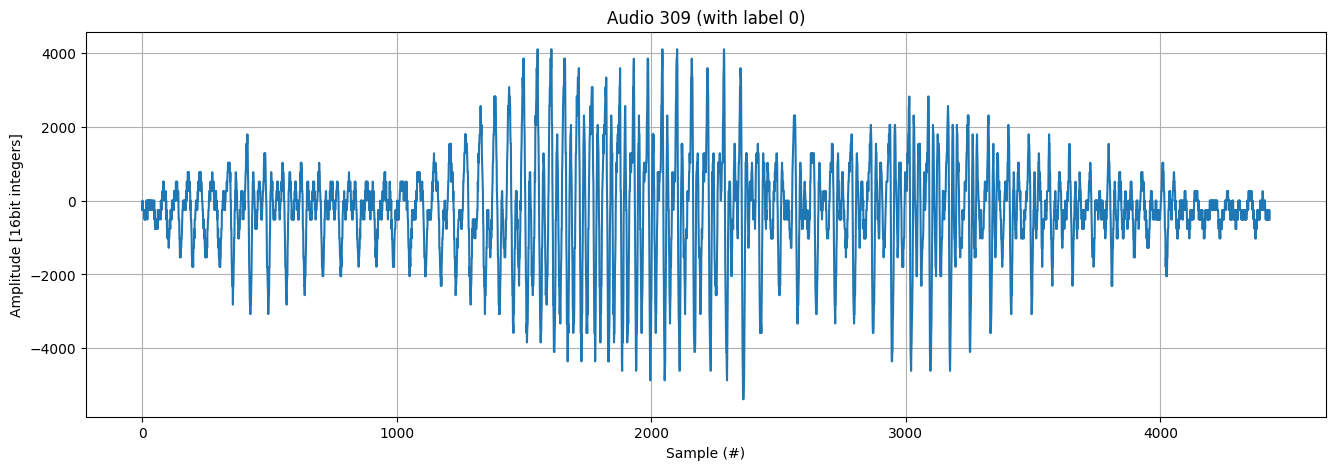

In [38]:
fig, ax = plt.subplots(figsize = (16, 5)) # create figure

sample_axis: np.array = np.linspace(0.0, data.shape[0], data.shape[0]) # create x axis
ax.plot(sample_axis, data, label = f'Idx: {test_element.name}, Label: {test_element['label']}') # plot

ax.set_xlabel(xlabel = 'Sample (#)')
ax.set_ylabel(ylabel = 'Amplitude [16bit integers]')
ax.grid()

plt.title(f'Audio {test_element.name} (with label {test_element['label']})')
plt.show()

## 3. Pre-processing

### Normalize waveform

Since many audio files have different volume level and different length, to be able to compere them it's necessary to perform some tranformation.

A first operation might be an audio signal normalization, which permits us to compere audio with different volumes

In [39]:
def normalize_audio(audio_data, samplerate = 8000, target_level=1.0)-> np.array:
    """Normalizes audio data.

    Args:
      audio_data: The audio data as a numpy array.
      samplerate: The sample rate of the audio.
      target_level: The target level for normalization.

    Returns:
      A numpy array containing the normalized audio data.
    """

    # Peak normalization
    peak: int = np.max(np.abs(audio_data))
    normalized_data: np.array = audio_data * (target_level / peak)

    return normalized_data

Let's then compare the original and the normalized signal

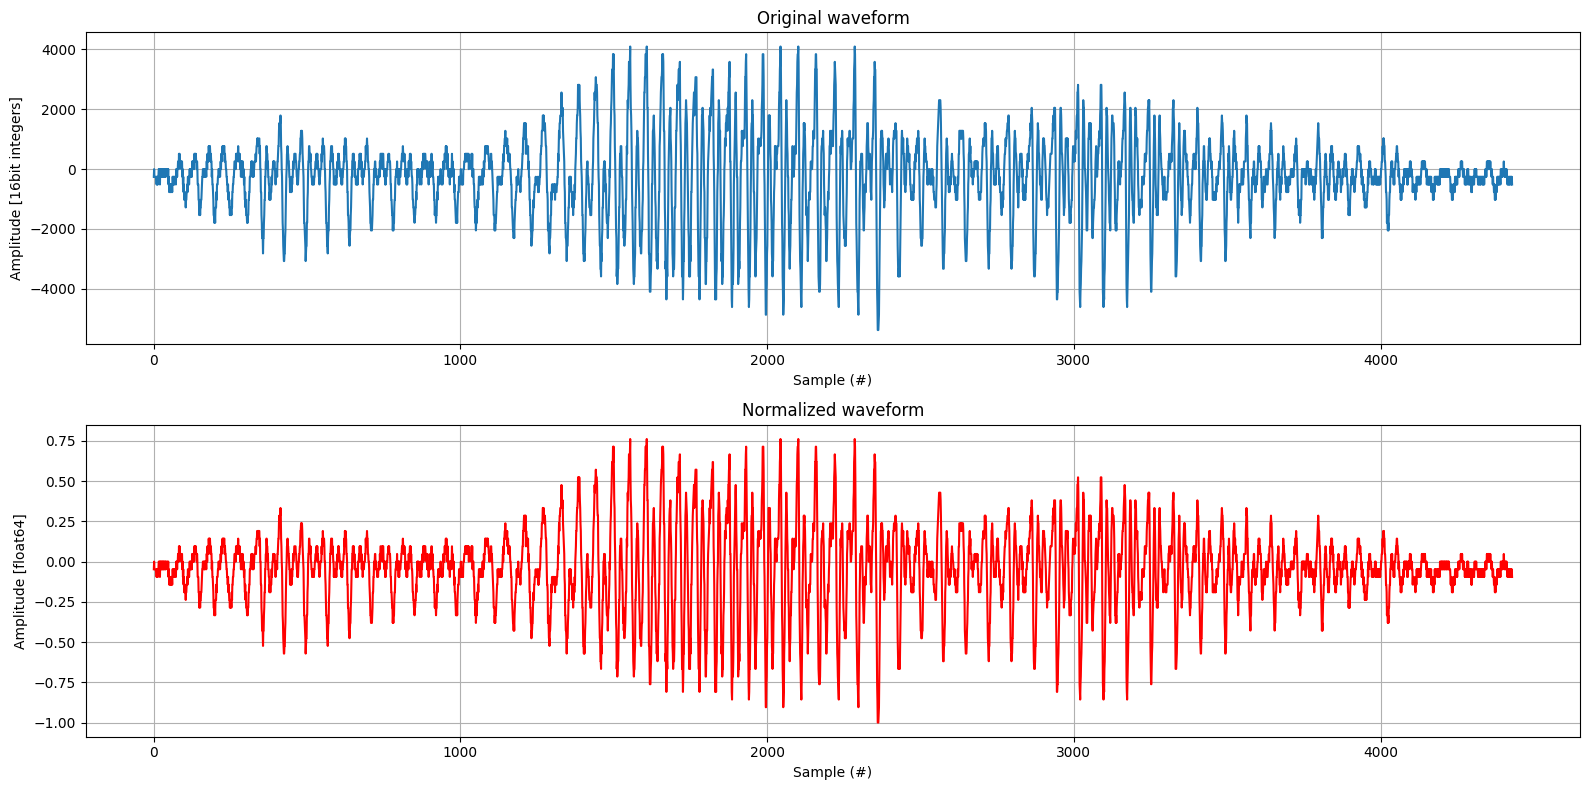

In [40]:
peak_test: np.array = normalize_audio(data, sample_rate)
# print(f'Normalized shape {peak_test.shape}; Normalized Data Type {peak_test.dtype}')

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 8)) # create figure

ax[0].plot(sample_axis, data)
ax[0].set_xlabel(xlabel = 'Sample (#)')
ax[0].set_ylabel(ylabel = 'Amplitude [16bit integers]')
ax[0].set_title('Original waveform')
ax[0].grid()

ax[1].plot(sample_axis, peak_test, c = 'red')
ax[1].set_xlabel(xlabel = 'Sample (#)')
ax[1].set_ylabel(ylabel = 'Amplitude [float64]')
ax[1].set_title('Normalized waveform')
ax[1].grid()

plt.tight_layout()
plt.show()

### Split the audio recording

Its easy to spot on the waveform that there are some places that have a very low volume respect to other parts, typically the center. Those are the usually places where the backgroung noise is predominant, meaning that it can be ignored since it doesnt provide any usefull information. Before extract the features that classification models will use to compare the recordings, we can try to split each audio in blocks with meaningfull data and use those blocks for the feature extraction.

In this case we will first find all the points that are above a given threshold (that we can think as were the voice have an higher volume that the noise), then we can try create blocks of data starting from those points. We can add some options to tweek the block creation:
- min_block: the block must have a meaningfull size. Block with smaller size will generate from spike in the waveform, usually a loud noise which is, of course, not relevant data;
- distance: we can aggregate smaller block into a single bigger block if they are close to each other, so we can avoid to discard data that might be still part of a recording.

In [41]:
def split_audio_blocks(data: np.array, threshold: float = .2, min_block: int = 150, distance: int = 50) -> list[tuple]:
    """Split the audio in blocks of relevant data

    Args:
        data (np.array): Normalized data array
        threshold (float, optional): Points that are above the threshold should be considered as voice. Defaults to .15.
        min_block (int, optional): Minimum size of each block. Defaults to 100.
        distance (int, optional): If the distance between two blocks is less than this value, the two blocks will be merged. Defaults to 25.

    Returns:
        list[tuple]: Each tuple represent a block, with values:
            -> start: starting point
            -> end: ending point
            -> size: size of the block (end - start)
    """
    
    voice: np.array = np.abs(data)
    indexes: np.array = np.where(voice > threshold)[0] # All point above the treshold
    
    # add 0 and voice.shape[0]
    if indexes[0] != 0:
        indexes = np.insert(indexes, 0, 0)
    if indexes[-1] != voice.shape[0]:
        indexes = np.insert(indexes, indexes.shape[0], voice.shape[0])
    
    
    blocks: list[tuple] = []
    start_block: int = -1
    at_least_one = False
    for idx in indexes:
        if start_block < 0: # start the creation of a new block
            start_block = idx
            current: int = start_block
            continue

        if idx - current < distance: # add element to a block
            current = idx
        else:
            at_least_one = True
            # block created
            if current - start_block > min_block: # check if the block is big enough to be saved
                blocks.append((start_block, current, current - start_block))
            
            start_block = -1
    
    if not at_least_one:
        # The entire audio is valid
        blocks.append((indexes[0], indexes[-1], indexes[-1] - indexes[0]))
    return blocks

def print_pretty_blocks(blocks: list[tuple]):
    print(f'Block(s) found: {len(blocks)}')
    for i, block in enumerate(blocks):
        print(f'{i+1}) Start: {int(block[0])}, End: {int(block[1])}, Size: {int(block[2])}')
    print()

# Using the test audio
blocks: list[tuple] = split_audio_blocks(peak_test) # default options
print_pretty_blocks(blocks)

blocks = split_audio_blocks(peak_test, threshold = .1, distance = 15, min_block = 40) # adding some options
print_pretty_blocks(blocks)

Block(s) found: 5
1) Start: 148, End: 430, Size: 282
2) Start: 1109, End: 2439, Size: 1330
3) Start: 2498, End: 2654, Size: 156
4) Start: 2710, End: 3418, Size: 708
5) Start: 3481, End: 3657, Size: 176

Block(s) found: 15
1) Start: 336, End: 383, Size: 47
2) Start: 407, End: 449, Size: 42
3) Start: 1143, End: 2515, Size: 1372
4) Start: 2543, End: 2594, Size: 51
5) Start: 2614, End: 2662, Size: 48
6) Start: 2689, End: 2734, Size: 45
7) Start: 2752, End: 3142, Size: 390
8) Start: 3158, End: 3221, Size: 63
9) Start: 3238, End: 3383, Size: 145
10) Start: 3400, End: 3464, Size: 64
11) Start: 3480, End: 3541, Size: 61
12) Start: 3561, End: 3622, Size: 61
13) Start: 3641, End: 3698, Size: 57
14) Start: 3782, End: 3870, Size: 88
15) Start: 3894, End: 3957, Size: 63



Lets visualize the blocks created on the test example

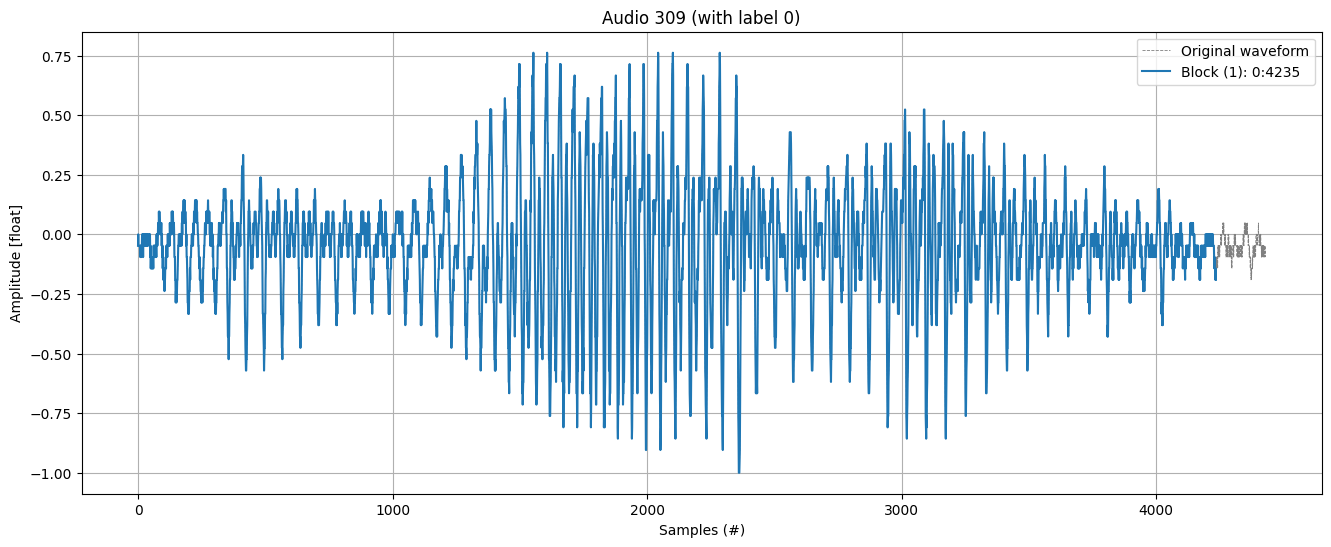

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))

blocks: list[tuple] = split_audio_blocks(peak_test)

# full waveform
samples_axis = np.linspace(0, peak_test.shape[0], peak_test.shape[0])
ax.plot(samples_axis, peak_test, label = 'Original waveform', linestyle = '--', linewidth = .6, c='gray')

for i, block in enumerate(blocks):
    # draw new line on top of the original plot for each block
    interval_samples = np.linspace(block[0], block[1], block[2])
    ax.plot(interval_samples, peak_test[block[0]:block[1]], label = f'Block ({i+1}): {block[0]}:{block[1]}')
    
ax.set_xlabel(xlabel = 'Samples (#)')
ax.set_ylabel(ylabel = 'Amplitude [float]')
ax.legend()
ax.grid()

plt.title(f'Audio {test_element.name} (with label {test_element['label']})')
plt.show()

### Find adequate values for the block division

In same cases, the waveform has a weird shape, with multiple spike or with similar volume. With those audio will be better to change the options in the block creation, so we can get blocks that contain useful information.

Lets first update the data frame by adding the following column:
- sample rate;
- waveform;
- normalized waveform;
- blocks;

In [43]:
# Sample rate and waveform
df_update = pd.DataFrame({'sample_rate': wav[0], 'waveform': wav[1], 'length': len(wav[1])/wav[0]} for wav in dev_dataset['wav_data'])

# Normalized wave_form
df_update['normalized'] = pd.Series([normalize_audio(wav) for wav in df_update['waveform']])

# blocks
df_update['blocks'] = pd.Series([split_audio_blocks(norm_wave) for norm_wave in df_update['normalized']])
df_update['num_blocks'] = pd.Series([len(blocks) for blocks in df_update['blocks']])

dev_dataset = pd.concat([dev_dataset, df_update], axis = 1)
dev_dataset.head()

,label,full_path,wav_data,sample_rate,waveform,length,normalized,blocks,num_blocks
0,4,dataset\development\0_4.wav,"(8000, [14, 21, 0, 18, -11, 22, -15, -53, 9, -...",8000,"[14, 21, 0, 18, -11, 22, -15, -53, 9, -14, 11,...",0.390500,"[0.001352657004830918, 0.002028985507246377, 0...","[(195, 1444, 1249)]",1
1,7,dataset\development\1_7.wav,"(8000, [-2, 12, 1, -18, 7, -7, 1, -1, 0, 0, -6...",8000,"[-2, 12, 1, -18, 7, -7, 1, -1, 0, 0, -6, -9, 1...",0.405875,"[-0.0010610079575596816, 0.006366047745358089,...","[(470, 1201, 731)]",1
2,5,dataset\development\2_5.wav,"(8000, [-9, -7, -5, -8, -13, -1, 20, -12, 6, 1...",8000,"[-9, -7, -5, -8, -13, -1, 20, -12, 6, 15, 3, 2...",0.416375,"[-0.0023752969121140144, -0.001847453153866455...","[(416, 1130, 714)]",1
3,2,dataset\development\3_2.wav,"(8000, [-256, -512, 0, -256, 256, -256, 0, -51...",8000,"[-256, -512, 0, -256, 256, -256, 0, -512, 0, -...",0.341250,"[-0.05263157894736842, -0.10526315789473684, 0...","[(894, 1674, 780)]",1
4,3,dataset\development\4_3.wav,"(8000, [-20, 10, 26, -13, 22, -16, 11, 7, -21,...",8000,"[-20, 10, 26, -13, 22, -16, 11, 7, -21, 1, 63,...",0.241375,"[-0.023952095808383235, 0.011976047904191617, ...","[(467, 1604, 1137)]",1


In [45]:
grouped = dev_dataset.groupby('num_blocks')

for k, group in grouped:
    print(k, len(group))

0 2
1 1168
2 283
3 39
4 6
5 2


In [ ]:
zeros = dev_dataset['num_blocks'] < 1
too_much = dev_dataset['num_blocks'] > 2
strange_blocks = dev_dataset[zeros | too_much].index

for index in dev_dataset[zeros].index:
    dev_dataset.at[index, 'blocks'] = split_audio_blocks(dev_dataset.loc[index]['normalized'], threshold=.1)
    dev_dataset.at[index, 'num_blocks'] = len(dev_dataset.loc[index]['blocks'])
    
for index in dev_dataset[too_much].index:
    dev_dataset.at[index, 'blocks'] = split_audio_blocks(dev_dataset.loc[index]['normalized'], threshold = .15, distance = 100)
    dev_dataset.at[index, 'num_blocks'] = len(dev_dataset.loc[index]['blocks'])

# dev_dataset.iloc[strange_blocks]

In [47]:
grouped = dev_dataset.groupby('num_blocks')

for k, group in grouped:
    print(k, len(group))

1 1211
2 289
